In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import random
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, utils, models
from tqdm import tnrange
from time import time
from IPython.display import clear_output

## VGG-16 on CIFAR10

In [2]:
data_transform_train = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_cifar10 = datasets.CIFAR10(root='cifar10/train', train=True, transform=data_transform_train, download=True)
test_cifar10 = datasets.CIFAR10(root='cifar10/test', train=False, transform=data_transform_test, download=True)

dataset_loader_train = torch.utils.data.DataLoader(train_cifar10, batch_size=32, shuffle=True, num_workers=4)
dataset_loader_test = torch.utils.data.DataLoader(test_cifar10, batch_size=32, shuffle=False, num_workers=4)

/anaconda/envs/py36/lib/python3.6/site-packages/torchvision/transforms/transforms.py:694: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


Files already downloaded and verified
Files already downloaded and verified


In [3]:
def train_epoch(model, data_iter, criterion, optimizer):
    model.train()
    losses = []
    for _, batch in zip(tnrange(len(data_iter)), data_iter):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
    
        optimizer.zero_grad()
        
        out = model(images)
        loss = criterion(out, labels)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    return losses

def val(model, data_iter, criterion):
    model.eval()
    losses = []
    acc = 0.0
    with torch.no_grad():
        for _, batch in zip(tnrange(len(data_iter)), data_iter):
            images, labels = batch
            images, labels = images.cuda(), labels.cuda()

            out = model(images)
            loss = criterion(out, labels)
            _, preds = torch.max(out, 1)
            acc += torch.sum(preds == labels).type(torch.float)

            losses.append(loss.item())
    return losses, acc / len(data_iter.dataset)

In [4]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def plot_accs(accs, title='val accuracy'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(accs, label='val acc')

    plt.xlabel('epoch')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, opt, crit, train_iter, val_iter, num_epochs, sched, checkpoint_epoch, n_model, n_classes):
    train_log, val_log = [], []
    val_accs = []
    last_acc = 0.0
    
    t1 = time()
    
    for epoch in range(num_epochs):
        tic = time()
        train_loss = train_epoch(model, train_iter, crit, opt)
        tac = time()

        tic1 = time()
        val_loss, val_acc = val(model, val_iter, crit)
        tac1 = time()
        
        val_accs.append(val_acc)
        
        sched.step()
        
        train_log.extend(train_loss)

        val_log.append((len(train_iter) * (epoch + 1), np.mean(val_loss)))

        clear_output()
        plot_history(train_log, val_log)
        if epoch:
            plot_accs(val_accs)
        t2 = time()
        print('EPOCH {}:'.format(epoch))
        print('Total time from start: {}min {}s'.format((t2 - t1) // 60, (t2 - t1) % 60))
        print('TRAIN: {}min {}s for epoch, mean loss = {}'.format((tac - tic) // 60, (tac - tic) % 60, np.mean(train_loss)))
        print('VAL: {}min {}s for epoch, mean loss = {}, acc = {}'.format((tac1 - tic1) // 60, (tac1 - tic1) % 60, np.mean(val_loss), val_acc))
        last_acc = val_acc
        if epoch == checkpoint_epoch:
            torch.save(model.state_dict(), 'vgg16_cifar{}_32ep_{}.pt'.format(n_classes, n_model))
            torch.save(opt.state_dict(), 'vgg16_cifar{}_32ep_{}_opt.pt'.format(n_classes, n_model))
    
    return train_log, val_log, last_acc, model

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [6]:
vgg16_cifar10 = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10 = vgg16_cifar10.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar10.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)

sched = MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

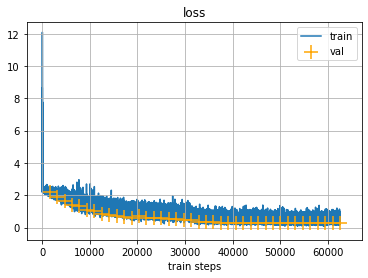

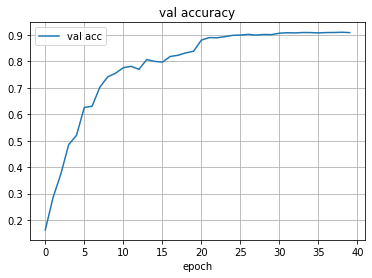

EPOCH 39:
Total time from start: 854.0min 33.004735469818115s
TRAIN: 20.0min 8.454360485076904s for epoch, mean loss = 0.5102844840047913
VAL: 1.0min 13.495221614837646s for epoch, mean loss = 0.26511021370228866, acc = 0.9086999893188477


In [7]:
train_log, val_log, vgg16_cifar10_1_acc, vgg16_cifar10 = train(vgg16_cifar10, optimizer, criterion, dataset_loader_train, dataset_loader_test, 40, sched, 31, 1, 10)

In [8]:
vgg16_cifar10_1_acc

tensor(0.9087, device='cuda:0')

In [9]:
torch.save(vgg16_cifar10.state_dict(), 'vgg16_cifar10_40ep_1.pt')

In [10]:
random.seed(8)
np.random.seed(8)
torch.manual_seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8)

In [11]:
vgg16_cifar10 = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10 = vgg16_cifar10.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar10.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)

sched = MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

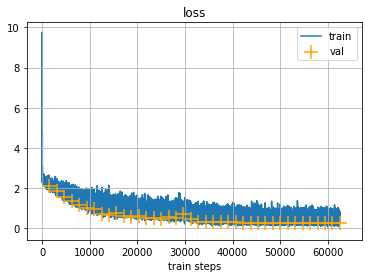

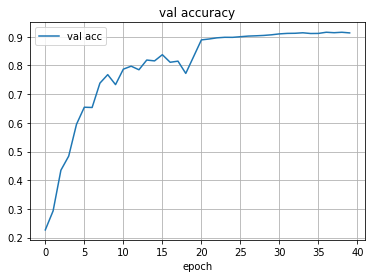

EPOCH 39:
Total time from start: 873.0min 44.08471870422363s
TRAIN: 20.0min 36.97029948234558s for epoch, mean loss = 0.48787394633620346
VAL: 1.0min 13.490675449371338s for epoch, mean loss = 0.2521608437354953, acc = 0.9134999513626099


In [12]:
train_log, val_log, vgg16_cifar10_2_acc, vgg16_cifar10 = train(vgg16_cifar10, optimizer, criterion, dataset_loader_train, dataset_loader_test, 40, sched, 31, 2, 10)

In [13]:
vgg16_cifar10_2_acc

tensor(0.9135, device='cuda:0')

In [14]:
torch.save(vgg16_cifar10.state_dict(), 'vgg16_cifar10_40ep_2.pt')

In [5]:
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3)

In [6]:
vgg16_cifar10 = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10 = vgg16_cifar10.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar10.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)

sched = MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

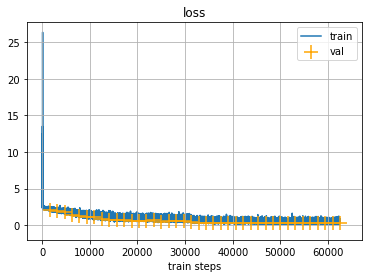

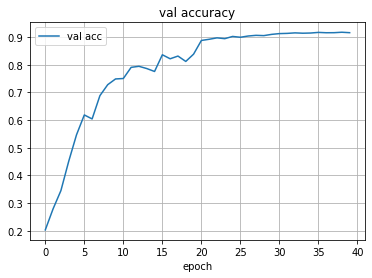

EPOCH 39:
Total time from start: 859.0min 42.37006425857544s
TRAIN: 20.0min 9.596408367156982s for epoch, mean loss = 0.4939222534688253
VAL: 1.0min 13.772108793258667s for epoch, mean loss = 0.2469707869540769, acc = 0.9158999919891357


In [7]:
train_log, val_log, vgg16_cifar10_3_acc, vgg16_cifar10 = train(vgg16_cifar10, optimizer, criterion, dataset_loader_train, dataset_loader_test, 40, sched, 31, 3, 10)

In [8]:
vgg16_cifar10_3_acc

tensor(0.9159, device='cuda:0')

In [9]:
torch.save(vgg16_cifar10.state_dict(), 'vgg16_cifar10_40ep_3.pt')

## VGG-16 on CIFAR100

In [10]:
data_transform_train = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_cifar100 = datasets.CIFAR100(root='cifar100/train', train=True, transform=data_transform_train, download=True)
test_cifar100 = datasets.CIFAR100(root='cifar100/test', train=False, transform=data_transform_test, download=True)

dataset_loader_train = torch.utils.data.DataLoader(train_cifar100, batch_size=32, shuffle=True, num_workers=4)
dataset_loader_test = torch.utils.data.DataLoader(test_cifar100, batch_size=32, shuffle=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [6]:
vgg16_cifar100 = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100 = vgg16_cifar100.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar100.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)

sched = MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

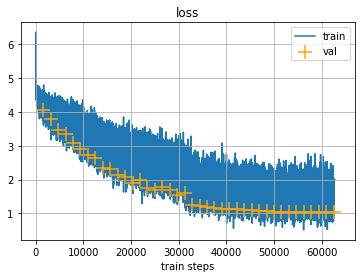

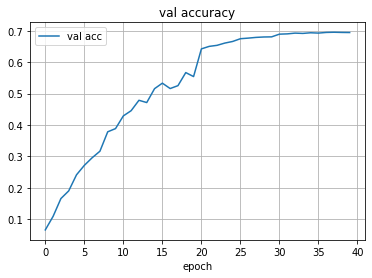

EPOCH 39:
Total time from start: 856.0min 42.106281042099s
TRAIN: 20.0min 12.96396255493164s for epoch, mean loss = 1.4852578852394798
VAL: 1.0min 13.636692523956299s for epoch, mean loss = 1.0353483877623806, acc = 0.6940999627113342


In [7]:
train_log, val_log, vgg16_cifar100_1_acc, vgg16_cifar100 = train(vgg16_cifar100, optimizer, criterion, dataset_loader_train, dataset_loader_test, 40, sched, 31, 1, 100)

In [8]:
vgg16_cifar100_1_acc

tensor(0.6941, device='cuda:0')

In [9]:
torch.save(vgg16_cifar100.state_dict(), 'vgg16_cifar100_40ep_1.pt')

In [10]:
random.seed(8)
np.random.seed(8)
torch.manual_seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8)

In [11]:
vgg16_cifar100 = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100 = vgg16_cifar100.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar100.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)

sched = MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

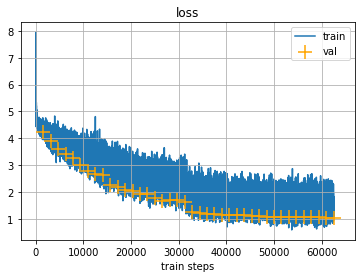

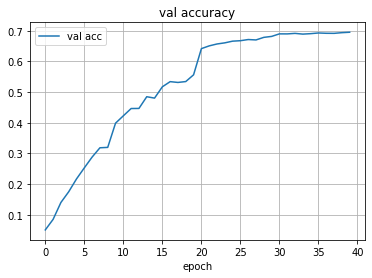

EPOCH 39:
Total time from start: 872.0min 1.7317636013031006s
TRAIN: 20.0min 34.015554666519165s for epoch, mean loss = 1.5393325974372283
VAL: 1.0min 13.48140573501587s for epoch, mean loss = 1.0500083393372668, acc = 0.6953999996185303


In [12]:
train_log, val_log, vgg16_cifar100_2_acc, vgg16_cifar100 = train(vgg16_cifar100, optimizer, criterion, dataset_loader_train, dataset_loader_test, 40, sched, 31, 2, 100)

In [13]:
vgg16_cifar100_2_acc

tensor(0.6954, device='cuda:0')

In [14]:
torch.save(vgg16_cifar100.state_dict(), 'vgg16_cifar100_40ep_2.pt')

In [11]:
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3)

In [12]:
vgg16_cifar100 = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100 = vgg16_cifar100.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar100.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)

sched = MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

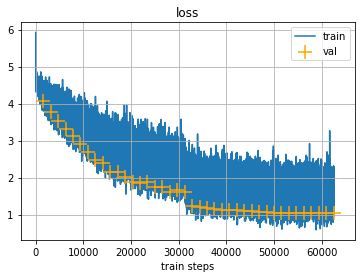

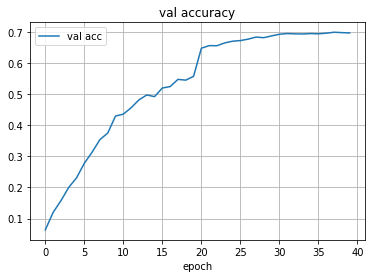

EPOCH 39:
Total time from start: 871.0min 53.78129172325134s
TRAIN: 20.0min 40.207634687423706s for epoch, mean loss = 1.4999220484887952
VAL: 1.0min 13.948832035064697s for epoch, mean loss = 1.0329527063682056, acc = 0.6960999965667725


In [13]:
train_log, val_log, vgg16_cifar100_3_acc, vgg16_cifar100 = train(vgg16_cifar100, optimizer, criterion, dataset_loader_train, dataset_loader_test, 40, sched, 31, 3, 100)

In [14]:
vgg16_cifar100_3_acc

tensor(0.6961, device='cuda:0')

In [15]:
torch.save(vgg16_cifar100.state_dict(), 'vgg16_cifar100_40ep_3.pt')